<a href="https://colab.research.google.com/github/Birkbeck/msc-projects-2023-4-Gabriele_Monti_PEFT/blob/main/adapters_classifcation_project_PEFT_Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is originally taken from https://colab.research.google.com/github/Adapter-Hub/adapters/blob/main/notebooks/01_Adapter_Training.ipynb

This code was originally sourced from a Colab notebook provided by Adapter-Hub, available at this link above. The example demonstrates how to integrate a bottleneck adapter into the output stage of the RoBERTa model. This setup is specifically tailored for sentiment analysis tasks, where it has shown to perform very effectively.


In [ ]:
!pip install -qq adapters datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.0/263.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 

In [ ]:
#using the imdb for classifing the text

from datasets import load_dataset

dataset = load_dataset("imdb")
dataset.num_rows

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'train': 25000, 'test': 25000, 'unsupervised': 50000}

In [ ]:
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [ ]:
#this tokenise the input for batch processing

from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch["text"], max_length=80, truncation=True, padding="max_length")

# Encode the input data
dataset = dataset.map(encode_batch, batched=True)
# The transformers model expects the target class column to be named "labels"
dataset = dataset.rename_column(original_column_name="label", new_column_name="labels")
# Transform to pytorch tensors and only output the required columns
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
dataset['train']['input_ids'][0]

tensor([    0,   100, 16425,    38,  3326,   230, 42338, 18024,    12,   975,
        25322,  4581,    31,   127,   569,  1400,   142,     9,    70,     5,
         6170,    14,  7501,    24,    77,    24,    21,    78,   703,    11,
        13025,     4,    38,    67,  1317,    14,    23,    78,    24,    21,
         5942,    30,   121,     4,   104,     4, 10102,   114,    24,   655,
         1381,     7,  2914,    42,   247,     6,  3891,   145,    10,  2378,
            9,  3541,  1687,    22, 10800, 34689,   113,    38,   269,    56,
            7,   192,    42,    13,  2185, 49069,  3809,  1589, 49007,     2])

In [ ]:
# Load the configuration for the RoBERTa model with predefined settings for binary classification (num_labels=2)

from transformers import RobertaConfig
from adapters import AutoAdapterModel

config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=2,
)
model = AutoAdapterModel.from_pretrained(
    "roberta-base",
    config=config,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaAdapterModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['heads.default.3.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Add a new adapter, here we create the bottle neck adapter
model.add_adapter("IMDB", config="seq_bn")
# Alternatively, e.g.:
# model.add_adapter("rotten_tomatoes", config="lora")

# Add a matching classification head
model.add_classification_head(
    "IMDB",
    num_labels=2,
    id2label={ 0: "👎", 1: "👍"}
  )

# Activate the adapter
model.train_adapter("IMDB")

In [ ]:
#call back function for measuring the loss during training

from transformers import TrainingArguments, TrainerCallback, EvalPrediction

# Custom Callback to Log Loss
class LossLoggingCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # This method is called whenever the logging step is reached.
        if logs is not None and 'loss' in logs:
            self.losses.append(logs['loss'])

loss_logging_callback = LossLoggingCallback()


In [ ]:
#training function

import numpy as np
from transformers import TrainingArguments, EvalPrediction
from adapters import AdapterTrainer

training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=200,
    output_dir="./training_output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  return {"acc": (preds == p.label_ids).mean()}

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_accuracy,
    callbacks=[loss_logging_callback]  # Add your custom callback here
)

In [ ]:
trainer.train()

Step,Training Loss
200,0.272800
400,0.282200
600,0.303100
800,0.317600
1000,0.288700
1200,0.286300
1400,0.286200
1600,0.280400
1800,0.271400
2000,0.276700


TrainOutput(global_step=3910, training_loss=0.2701287979360127, metrics={'train_runtime': 308.2461, 'train_samples_per_second': 405.52, 'train_steps_per_second': 12.685, 'total_flos': 5266538580000000.0, 'train_loss': 0.2701287979360127, 'epoch': 5.0})

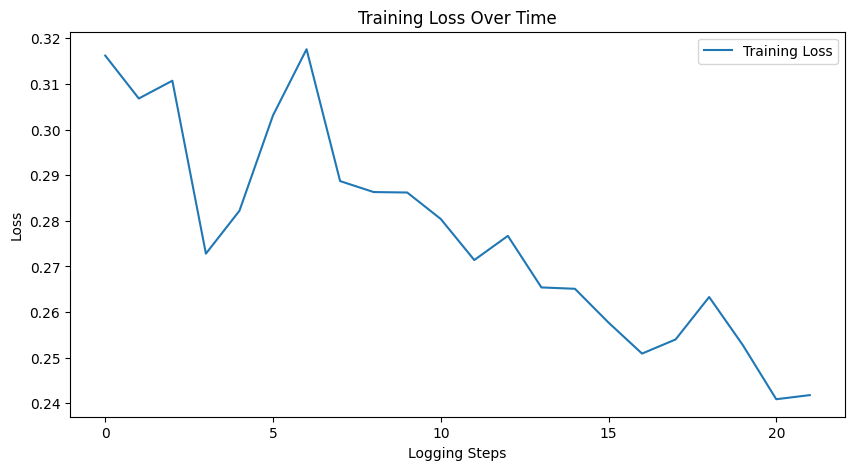

In [ ]:
# Access the recorded losses after training
losses = loss_logging_callback.losses

# Optional: Plot the losses using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Logging Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

Here we can see that the model is performing well on the evaluation data.

In [ ]:
trainer.evaluate()

{'eval_loss': 0.28624439239501953,
 'eval_acc': 0.88168,
 'eval_runtime': 28.9882,
 'eval_samples_per_second': 862.42,
 'eval_steps_per_second': 26.976,
 'epoch': 5.0}

In [ ]:
model.adapter_summary("IMDB")

[{'name': 'IMDB',
  'architecture': 'bottleneck',
  'active': True,
  '#param': 894528,
  'train': True,
  '%param': 0.7176569171713936},
 {'name': 'Full model', '#param': 124645632, '%param': 100.0, 'train': False}]

In [ ]:
model

RobertaAdapterModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttentionWithAdapters(
              (query): LoRALinearTorch(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (key): LoRALinearTorch(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (value): LoRALinearTorch(
                in_features=768, out_features=768, bias=True
                (

In [ ]:
!pip install weightwatcher

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 997.8 kB/s eta 0:00:00


In [ ]:
import weightwatcher as ww

In [ ]:
watcher = ww.WeightWatcher(model=model)

# Analyze the model
results = watcher.analyze()

summary = watcher.get_summary(results)
summary

{'log_norm': 2.858529116537249,
 'alpha': 5.9876738661324636,
 'alpha_weighted': 5.119825736467351,
 'log_alpha_norm': 5.406150124597714,
 'log_spectral_norm': 1.3264896763470413,
 'stable_rank': 40.14458856421145}

The high alpha values indicate that the model might be long-tailed and able to capture more variance in the data.

In [ ]:
from transformers import TextClassificationPipeline

classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=training_args.device.index)

classifier("Edge of Darkness left me underwhelmed despite its promising premise. Mel Gibson's performance felt predictable in a plot that tried too hard to shock without much substance. The twists seemed forced and the emotional depth was lacking, making it a forgettable watch in the crowded field of better-executed thrillers.")

The model 'RobertaAdapterModel' is not supported for . Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification', 'GPT2ForSequenceClassification',

[{'label': '👎', 'score': 0.9669924378395081}]